## Imports and data set up

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sb
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import sklearn.linear_model as lm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
import sklearn.impute as im

from datetime import timedelta
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!ls gdrive/MyDrive/'AC297r Capstone QB Group'/Data

Mounted at /content/gdrive
 Aux			       test_counties.csv
'Dataset description.gsheet'   train_counties.csv
 Deprecated		       train_test_key.csv
 Merging.ipynb		       USDM
 NOAA			       USDM_SET_full.csv
'Sentinel Hub'		       USDM_SMAP_SET_9Counties.csv
 SET			       USDM_SMAP_SET_full.csv
 SMAP			       USDM_SMAP_SET_NOAA_full.csv
 smap_fip_tifs		       USDM_SMAP_SET_NOAA_STL_full.csv


In [ ]:
# df_full = pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/USDM_SMAP_SET_NOAA_full.csv')
# df_stl_region = pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/USDM_SMAP_SET_NOAA_STL_full.csv')

df_full = pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/USDM_SMAP_SET_NOAA_STL_full.csv')

train_counties, test_counties = pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/train_counties.csv'),pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/test_counties.csv')

df_full[df_full == -9999] = np.nan

train_counties.reset_index(inplace = True)
test_counties.reset_index(inplace = True)

df_full['test'] = [1 if fip in test_counties['FIPS'].unique() else 0 for fip in df_full['FIPS']]


df_full['MapDate'] = pd.to_datetime(df_full['MapDate'])

df_full.columns

Index(['Unnamed: 0', 'MapDate', 'FIPS', 'County', 'State', 'None', 'D0', 'D1',
       'D2', 'D3', 'D4', 'ValidStart', 'ValidEnd', 'StatisticFormatID', 'wsum',
       'FIPS STR', 'roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN',
       'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff',
       'Region', 'test'],
      dtype='object')

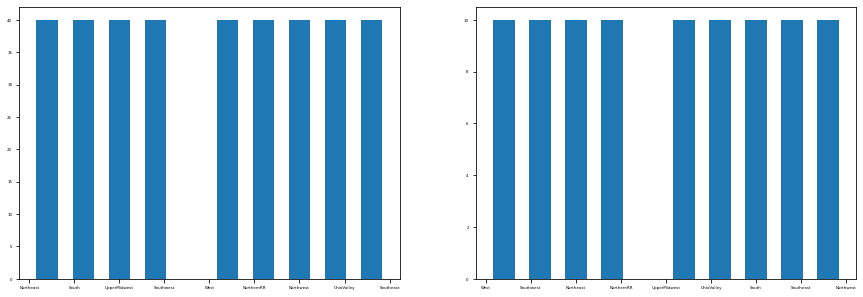

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].hist(train_counties['Region'], rwidth=0.6)
ax[0].tick_params(labelsize=4)

ax[1].hist(test_counties['Region'], rwidth=0.6)
ax[1].tick_params(labelsize=4)

plt.show()


In [ ]:
'''
Function below takes following args:
 - model: Sklearn model (e.g. OLS, LinearRegression)
 - X_list: list of predictor labels
 - y_list: list of response labels
 - start_pred: date to begin predicting from formated "YYYY-MM-DD"
 - pred_time: number of weeks after start_pred to predict
 - lag: number of weeks X should be offset to predict Y (default = 1)
 - remove_na: remove NA values from df before modeling (default = True)

Returns:
- fitted model fit to lagged X
- predicted values based on lagged X_test
- MSE based on start_pred and pred_time
'''
# have to change to drop y based on index of X


def build_model(model, df, df_test, X_list, y_list, start_pred, pred_time, start_train = '2012-01-01', lag = 1, remove_na = True, loss = mean_squared_error, flatten = True):


    df = df.sort_values('MapDate')

    df = df.loc[df['MapDate'] >= datetime.strptime(start_train, '%Y-%M-%d')]
    
    X_train = df.loc[df['MapDate'] < datetime.strptime(start_pred, '%Y-%M-%d') - timedelta(weeks = lag), X_list]

    y_train = df.loc[df['MapDate'] >= (min(df['MapDate']) + timedelta(weeks = lag)),:]
    y_train = y_train.loc[y_train['MapDate'] <= start_pred, y_list]


    if (len(df_test) == len(df)):

        df_test = df[df['MapDate'] >= datetime.strptime(start_pred, '%Y-%M-%d') - timedelta(weeks = lag) ]
    
    else:
        df_test = df_test[df_test['MapDate'] >= datetime.strptime(start_pred, '%Y-%M-%d') - timedelta(weeks = lag) ]

    X_test = df_test[df_test['MapDate'] < datetime.strptime(start_pred, '%Y-%M-%d') - timedelta(weeks = lag) + timedelta(weeks = pred_time)][X_list]

    y_test = df_test[df_test['MapDate'] < datetime.strptime(start_pred, '%Y-%M-%d') + timedelta(weeks = pred_time)]
    y_test = y_test[y_test['MapDate'] >= datetime.strptime(start_pred, '%Y-%M-%d')][y_list]

    X_test = X_test.drop('MapDate', axis = 1)


    X_train = X_train.drop('MapDate', axis = 1)

    if remove_na:
        X_train = X_train.dropna()
        y_train = y_train.dropna()
        X_test = X_test.dropna()
        y_test = y_test.dropna()

        
    if flatten:
        fit = model.fit(X_train, y_train.values.flatten())
    else:
        fit = model.fit(X_train, y_train)
    
    
    prediction = model.predict(X_test)

    loss = loss(y_test, prediction)

    return fit, prediction, loss, model, X_test, y_test


def impute(df):
    imp = im.SimpleImputer()
    return imp.fit_transform(df)





In [ ]:
df_full.isna().sum()

Unnamed: 0                0
MapDate                   0
FIPS                      0
County                    0
State                     0
None                      0
D0                        0
D1                        0
D2                        0
D3                        0
D4                        0
ValidStart                0
ValidEnd                  0
StatisticFormatID         0
wsum                      0
FIPS STR                  0
roff                  74616
evap                  74616
smap                  78759
PRCP                  88334
SNWD                 132233
TMAX                  91431
TMIN                  91583
NDVI_1               117900
NDVI_2               117900
NDVI_diff            117900
NDRE_1               117900
NDRE_2               117900
NDRE_diff            117900
Region                    0
test                      0
dtype: int64

In [ ]:
# impute data

df_filled = df_full.copy()
df_filled['MapDate'] = (df_full['MapDate'] - df_full['MapDate'].min())  / np.timedelta64(1,'D')


X_list = ['roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']
y_list = ['None', 'D0', 'D1', 'D2', 'D3', 'D4', 'wsum']

vars = X_list.copy()
[vars.append(y) for y in y_list]

for fip in tqdm(df_filled['FIPS'].unique()):

    t_var = vars.copy()

    na_ind = np.where(df_filled.loc[df_filled['FIPS'] == fip, vars].isna().sum() == df_filled.loc[df_filled['FIPS'] == fip, vars].shape[0])

    if len(na_ind[0]) > 0:
        [t_var.remove(vars[ind]) for ind in na_ind[0]]

    df_filled.loc[df_filled['FIPS'] == fip, t_var] = df_filled.loc[df_filled['FIPS'] == fip, t_var].mask(df_filled.loc[df_filled['FIPS'] == fip, t_var].isna(), other = lambda x: x.mean(), axis = 1)


# Impute the rest based on national averages, in the future could use regional averages

df_filled[vars] = impute(df_filled[vars])

df_filled = df_filled.rename(columns = {'MapDate' : 'week'})
df_filled['MapDate'] = df_full['MapDate']

df_filled.isna().sum()


100%|██████████| 450/450 [00:32<00:00, 13.67it/s]


Unnamed: 0           0
week                 0
FIPS                 0
County               0
State                0
None                 0
D0                   0
D1                   0
D2                   0
D3                   0
D4                   0
ValidStart           0
ValidEnd             0
StatisticFormatID    0
wsum                 0
FIPS STR             0
roff                 0
evap                 0
smap                 0
PRCP                 0
SNWD                 0
TMAX                 0
TMIN                 0
NDVI_1               0
NDVI_2               0
NDVI_diff            0
NDRE_1               0
NDRE_2               0
NDRE_diff            0
Region               0
test                 0
MapDate              0
dtype: int64

In [ ]:
# RERUN WITH CAUTION
# Currently using impuation rather than dropping NAs

# df_filled = df_full.copy()
# df_filled['MapDate'] = (df_full['MapDate'] - df_full['MapDate'].min())  / np.timedelta64(1,'D')

# # Models
# model = lm.LinearRegression()


# # Parameters
# X_list = ['MapDate', 'roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']
# y_list = ['None', 'D0', 'D1', 'D2', 'D3', 'D4', 'wsum']

# vars = X_list.copy()
# [vars.append(y) for y in y_list]


# df_filled = impute(df_filled[vars], imputer)

# df_filled = pd.DataFrame(df_filled, columns = vars)

# df_filled = df_filled.rename(columns = {'MapDate' : 'week'})
# df_filled['MapDate'] = df_full['MapDate']

# X_list.append('week')

# define drought type as max of various levels of drought
df_filled['d_type'] = np.argmax([df_filled['None'] - df_filled['D0'] - df_filled['D1'] - df_filled['D2'] - df_filled['D3'] - df_filled['D4'], df_filled['D0'] - df_filled['D1'] - df_filled['D2'] - df_filled['D3'] - df_filled['D4'], df_filled['D1'] - df_filled['D2'] - df_filled['D3'] - df_filled['D4'],
           df_filled['D2'] - df_filled['D3'] - df_filled['D4'], df_filled['D3'] - df_filled['D4'], df_filled['D4']], axis = 0)


df_filled.head()


,Unnamed: 0,week,FIPS,County,State,None,D0,D1,D2,D3,...,NDVI_1,NDVI_2,NDVI_diff,NDRE_1,NDRE_2,NDRE_diff,Region,test,MapDate,d_type
0,1593,0.0,1007,Bibb County,AL,0.00,100.00,54.54,0.0,0.0,...,47.527389,47.562228,7.430438,52.461192,52.341242,94.491652,Southeast,0,2011-12-27,2
1,1594,7.0,1007,Bibb County,AL,0.00,100.00,54.54,0.0,0.0,...,47.527389,47.562228,7.430438,52.461192,52.341242,94.491652,Southeast,0,2012-01-03,2
2,1595,14.0,1007,Bibb County,AL,0.00,100.00,54.54,0.0,0.0,...,47.527389,47.562228,7.430438,52.461192,52.341242,94.491652,Southeast,0,2012-01-10,2
3,1596,21.0,1007,Bibb County,AL,41.41,58.59,0.00,0.0,0.0,...,47.527389,47.562228,7.430438,52.461192,52.341242,94.491652,Southeast,0,2012-01-17,1
4,1597,28.0,1007,Bibb County,AL,100.00,0.00,0.00,0.0,0.0,...,47.527389,47.562228,7.430438,52.461192,52.341242,94.491652,Southeast,0,2012-01-24,0


In [ ]:
df_train = df_filled[df_filled['test'] == 0]
df_test = df_filled[df_filled['test'] == 1]


## OLS Regression of weighted sum of drought index

In [ ]:
start_pred = '2021-01-01'
start_train = ['2012-01-01', '2015-01-01', '2017-01-01']

X_list = ['MapDate', 'week', 'roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']
y_list = ['wsum']

# test run
weeks = [4, 8, 12, 26, 52]
lags = [4, 8, 12, 26, 52]

results = np.zeros((len(lags), len(weeks), len(start_train)))

model = lm.LinearRegression()



for i, week in tqdm(enumerate(weeks)):
    for j, lag in enumerate(lags):
        for k, start in enumerate(start_train):
            res = build_model(model, df_train, df_test, X_list, y_list, start_pred, week, lag = lag, start_train = start)
            results[i, j, k] = res[2]

results = results.astype(float)



5it [00:44,  8.91s/it]


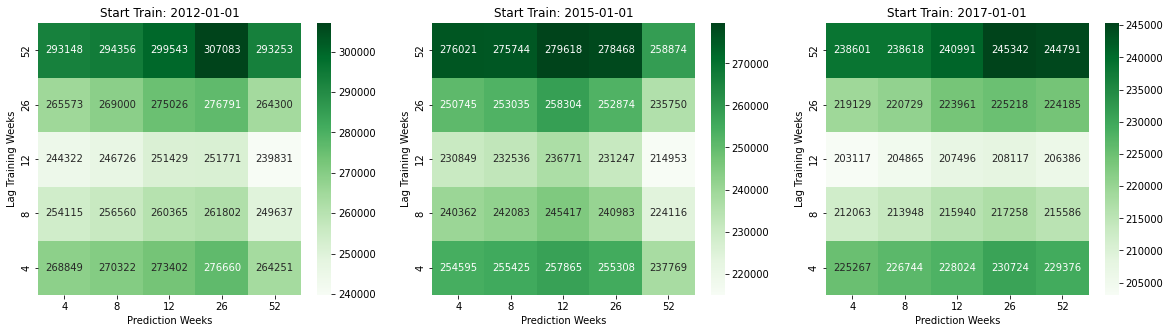

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (20,5))

sb.heatmap(results[:,:,0], annot = True, cmap = 'Greens', fmt='.0f', ax = ax[0], xticklabels = weeks, yticklabels=lags)
ax[0].set_title('Start Train: ' + start_train[0])
ax[0].set_xlabel('Prediction Weeks')
ax[0].set_ylabel('Lag Training Weeks')
ax[0].invert_yaxis()

sb.heatmap(results[:,:,1], annot = True, cmap = 'Greens', fmt='.0f', ax = ax[1], xticklabels = weeks, yticklabels=lags)
ax[1].set_title('Start Train: ' + start_train[1])
ax[1].set_xlabel('Prediction Weeks')
ax[1].set_ylabel('Lag Training Weeks')
ax[1].invert_yaxis()

sb.heatmap(results[:,:,2], annot = True, cmap = 'Greens', fmt='.0f', ax = ax[2], xticklabels = weeks, yticklabels=lags)
ax[2].set_title('Start Train: ' + start_train[2])
ax[2].set_xlabel('Prediction Weeks')
ax[2].set_ylabel('Lag Training Weeks')
ax[2].invert_yaxis()

plt.show()

In [ ]:

sum(df_filled['D0'] > 10) / len(df_filled['D0'])

0.5043440050219711

## Logistic Regression based on None along different thresholds

In [ ]:
start_pred = '2021-01-01'
start_train = ['2012-01-01', '2015-01-01', '2017-01-01']

X_list = ['MapDate', 'roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 
          'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff', 
          'Northeast', 'NorthernRR', 'Northwest', 'OhioValley', 'South', 'Southeast', 'Southwest', 'UpperMidwest', 'West']
y_list = ['None']

regions = ['Northeast', 'NorthernRR', 'Northwest', 'OhioValley', 'South', 'Southeast', 'Southwest', 'UpperMidwest', 'West']

norm = Normalizer()


df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

df_train_copy = df_train_copy.join(pd.get_dummies(df_train_copy['Region']))
df_test_copy = df_test_copy.join(pd.get_dummies(df_test_copy['Region']))


df_train_copy[['roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']] = norm.fit_transform(df_train_copy[['roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']])
df_test_copy[['roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']] = norm.transform(df_test_copy[['roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']])


In [ ]:
start_pred = '2021-01-01'
start_train = ['2012-01-01', '2015-01-01', '2017-01-01']

X_list = ['MapDate', 'roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 
          'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff', 
          'Northeast', 'NorthernRR', 'Northwest', 'OhioValley', 'South', 'Southeast', 'Southwest', 'UpperMidwest', 'West']
y_list = ['None']

regions = ['Northeast', 'NorthernRR', 'Northwest', 'OhioValley', 'South', 'Southeast', 'Southwest', 'UpperMidwest', 'West']

norm = Normalizer()


df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

df_train_copy = df_train_copy.join(pd.get_dummies(df_train_copy['Region']))
df_test_copy = df_test_copy.join(pd.get_dummies(df_test_copy['Region']))


df_train_copy[['roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']] = norm.fit_transform(df_train_copy[['roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']])
df_test_copy[['roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']] = norm.transform(df_test_copy[['roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']])



# test run
weeks = [4, 8, 12, 26, 52]
lags = [4, 8, 12, 26, 52]
thresholds = [10, 50, 90]

prec_rec_aucs = np.zeros((len(thresholds), len(lags), len(weeks), len(start_train)))


model = lm.LogisticRegression(max_iter = 1000, class_weight = 'balanced')


roc_aucs = []
results = []

for m, thresh in enumerate(thresholds):
    df_train_copy[y_list] = (df_train[y_list].values >= thresh).astype(int)
    df_test_copy[y_list] = (df_test[y_list].values >= thresh).astype(int)
    for i, week in tqdm(enumerate(weeks)):
        for j, lag in enumerate(lags):
            for k, start in enumerate(start_train):

                res = build_model(model, df_train_copy, df_test_copy, X_list, y_list, start_pred, week, lag = lag, start_train = start, loss = accuracy_score)
                
                lr_precision, lr_recall, _ = precision_recall_curve(res[5], res[0].predict_proba(res[4])[:,1])
                prec_rec_aucs[m, i, j, k] = auc(lr_recall, lr_precision)
                
                roc_aucs.append(roc_auc_score(res[5], res[0].predict_proba(res[4])[:,1]))
                results.append(res)
                
prec_rec_aucs = prec_rec_aucs.astype(float)


5it [02:48, 33.62s/it]
5it [02:55, 35.06s/it]
5it [02:36, 31.25s/it]


In [ ]:
[results[i][1].mean() for i in range(len(results))]

[0.825,
 0.7333333333333333,
 0.4666666666666667,
 0.8333333333333334,
 0.7555555555555555,
 0.6833333333333333,
 0.7833333333333333,
 0.6055555555555555,
 0.4888888888888889,
 0.8388888888888889,
 0.5305555555555556,
 0.15833333333333333,
 0.5888888888888889,
 0.29444444444444445,
 0.33055555555555555,
 0.8402777777777778,
 0.7444444444444445,
 0.4736111111111111,
 0.8458333333333333,
 0.7916666666666666,
 0.7111111111111111,
 0.7986111111111112,
 0.6861111111111111,
 0.5916666666666667,
 0.8222222222222222,
 0.5083333333333333,
 0.15,
 0.5833333333333334,
 0.2847222222222222,
 0.3,
 0.8388888888888889,
 0.7481481481481481,
 0.49722222222222223,
 0.8601851851851852,
 0.8009259259259259,
 0.725,
 0.8175925925925925,
 0.725925925925926,
 0.6388888888888888,
 0.8092592592592592,
 0.49166666666666664,
 0.16203703703703703,
 0.5657407407407408,
 0.325,
 0.30092592592592593,
 0.8115384615384615,
 0.67008547008547,
 0.48333333333333334,
 0.8371794871794872,
 0.744017094017094,
 0.65641025641

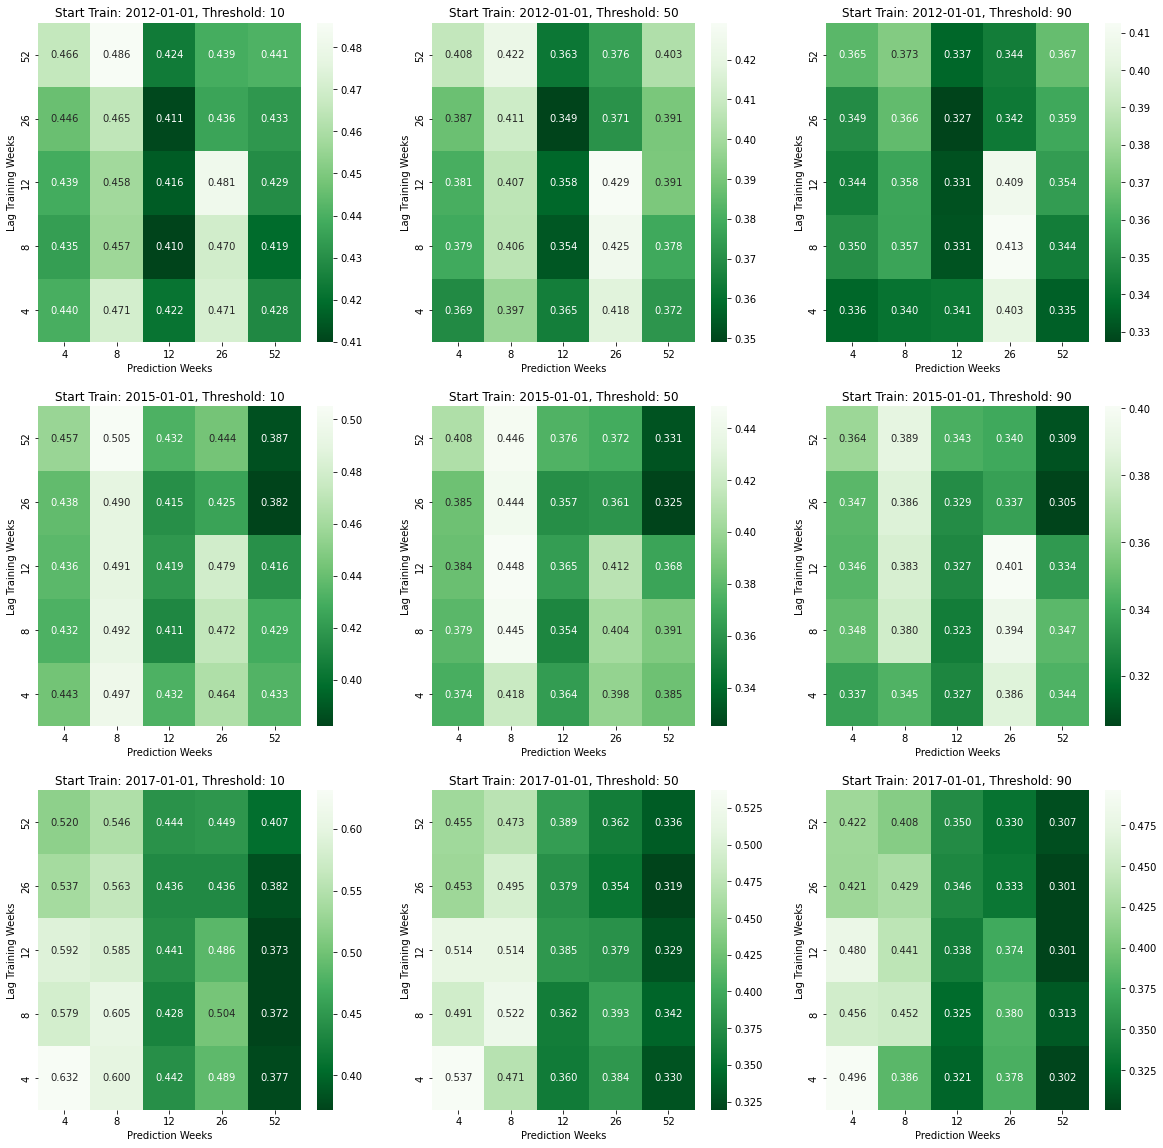

In [ ]:
fig, ax = plt.subplots(3,3, figsize = (20,20))

for i in range(3):
    sb.heatmap(prec_rec_aucs[i, :, :,0], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[0, i], xticklabels = weeks, yticklabels=lags)
    ax[0, i].set_title('Start Train: ' + start_train[0] + ', Threshold: ' + str(thresholds[i]))
    ax[0, i].set_xlabel('Prediction Weeks')
    ax[0, i].set_ylabel('Lag Training Weeks')
    ax[0, i].invert_yaxis()

    sb.heatmap(prec_rec_aucs[i, :, :,1], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[1, i], xticklabels = weeks, yticklabels=lags)
    ax[1, i].set_title('Start Train: ' + start_train[1] + ', Threshold: ' + str(thresholds[i]))
    ax[1, i].set_xlabel('Prediction Weeks')
    ax[1, i].set_ylabel('Lag Training Weeks')
    ax[1, i].invert_yaxis()

    sb.heatmap(prec_rec_aucs[i, :, :,2], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[2, i], xticklabels = weeks, yticklabels=lags)
    ax[2, i].set_title('Start Train: ' + start_train[2] + ', Threshold: ' + str(thresholds[i]))
    ax[2, i].set_xlabel('Prediction Weeks')
    ax[2, i].set_ylabel('Lag Training Weeks')
    ax[2, i].invert_yaxis()            

plt.show()



In [ ]:
start_pred = '2021-01-01'
start_train = ['2012-01-01', '2015-01-01', '2017-01-01']

X_list = ['MapDate', 'roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 
          'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']
y_list = ['None']


# test run
weeks = [4, 8, 12, 26, 52]
lags = [4, 8, 12, 26, 52]
thresholds =  [10, 50, 90]

prec_rec_aucs = np.zeros((len(thresholds), len(lags), len(weeks), len(start_train)))


model = lm.LogisticRegression(max_iter = 1000, class_weight = 'balanced')


roc_aucs = []
results = []

for m, thresh in enumerate(thresholds):
    df_train_copy[y_list] = (df_train[y_list].values >= thresh).astype(int)
    df_test_copy[y_list] = (df_test[y_list].values >= thresh).astype(int)
    for i, week in tqdm(enumerate(weeks)):
        for j, lag in enumerate(lags):
            for k, start in enumerate(start_train):

                res = build_model(model, df_train_copy, df_test_copy, X_list, y_list, start_pred, week, lag = lag, start_train = start, loss = accuracy_score)
                
                lr_precision, lr_recall, _ = precision_recall_curve(res[5], res[0].predict_proba(res[4])[:,1])
                prec_rec_aucs[m, i, j, k] = auc(lr_recall, lr_precision)
                
                roc_aucs.append(roc_auc_score(res[5], res[0].predict_proba(res[4])[:,1]))
                results.append(res)
                
prec_rec_aucs = prec_rec_aucs.astype(float)


5it [01:55, 23.05s/it]
5it [02:10, 26.04s/it]
5it [02:09, 25.83s/it]


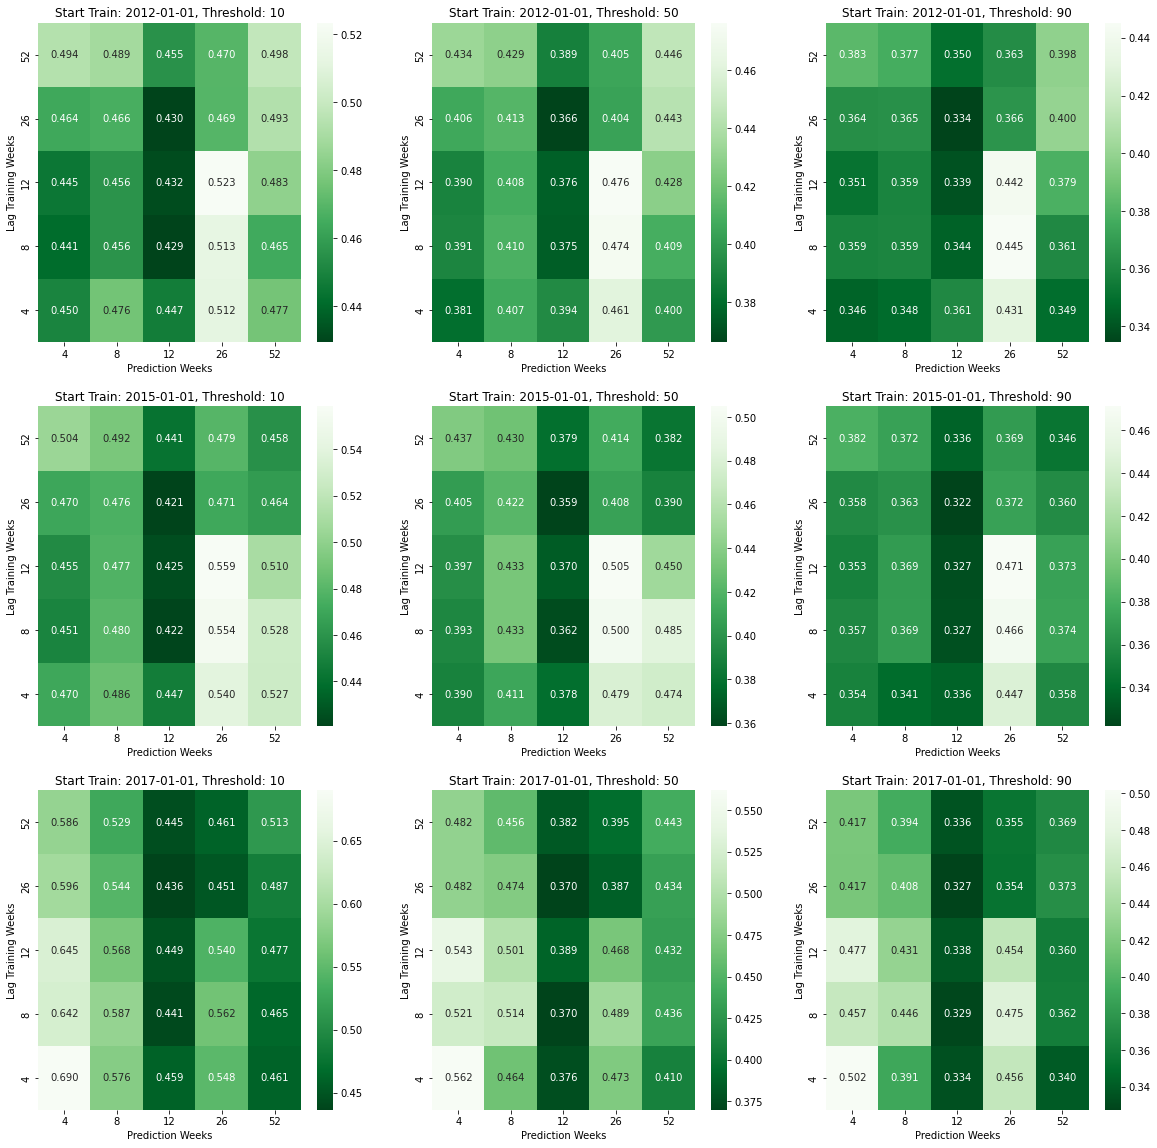

In [ ]:
fig, ax = plt.subplots(3,3, figsize = (20,20))

for i in range(3):
    sb.heatmap(prec_rec_aucs[i, :,:,0], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[0, i], xticklabels = weeks, yticklabels=lags)
    ax[0, i].set_title('Start Train: ' + start_train[0] + ', Threshold: ' + str(thresholds[i]))
    ax[0, i].set_xlabel('Prediction Weeks')
    ax[0, i].set_ylabel('Lag Training Weeks')
    ax[0, i].invert_yaxis()

    sb.heatmap(prec_rec_aucs[i, :,:,1], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[1, i], xticklabels = weeks, yticklabels=lags)
    ax[1, i].set_title('Start Train: ' + start_train[1] + ', Threshold: ' + str(thresholds[i]))
    ax[1, i].set_xlabel('Prediction Weeks')
    ax[1, i].set_ylabel('Lag Training Weeks')
    ax[1, i].invert_yaxis()

    sb.heatmap(prec_rec_aucs[i, :,:,2], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[2, i], xticklabels = weeks, yticklabels=lags)
    ax[2, i].set_title('Start Train: ' + start_train[2] + ', Threshold: ' + str(thresholds[i]))
    ax[2, i].set_xlabel('Prediction Weeks')
    ax[2, i].set_ylabel('Lag Training Weeks')
    ax[2, i].invert_yaxis()            

plt.show()

In [ ]:
start_pred = '2021-01-01'
start_train = ['2012-01-01', '2015-01-01', '2017-01-01']

X_list = ['MapDate', 'roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN']
y_list = ['None']


# test run
weeks = [4, 8, 12, 26, 52]
lags = [4, 8, 12, 26, 52]
thresholds =  [10, 50, 90]

prec_rec_aucs = np.zeros((len(thresholds), len(lags), len(weeks), len(start_train)))


model = lm.LogisticRegression(max_iter = 1000, class_weight = 'balanced')


roc_aucs = []
results = []

for m, thresh in enumerate(thresholds):
    df_train_copy[y_list] = (df_train[y_list].values >= thresh).astype(int)
    df_test_copy[y_list] = (df_test[y_list].values >= thresh).astype(int)
    for i, week in tqdm(enumerate(weeks)):
        for j, lag in enumerate(lags):
            for k, start in enumerate(start_train):

                res = build_model(model, df_train_copy, df_test_copy, X_list, y_list, start_pred, week, lag = lag, start_train = start, loss = accuracy_score)
                
                lr_precision, lr_recall, _ = precision_recall_curve(res[5], res[0].predict_proba(res[4])[:,1])
                prec_rec_aucs[m, i, j, k] = auc(lr_recall, lr_precision)
                
                roc_aucs.append(roc_auc_score(res[5], res[0].predict_proba(res[4])[:,1]))
                results.append(res)
                
prec_rec_aucs = prec_rec_aucs.astype(float)


5it [01:13, 14.78s/it]
5it [01:13, 14.65s/it]
5it [01:13, 14.62s/it]


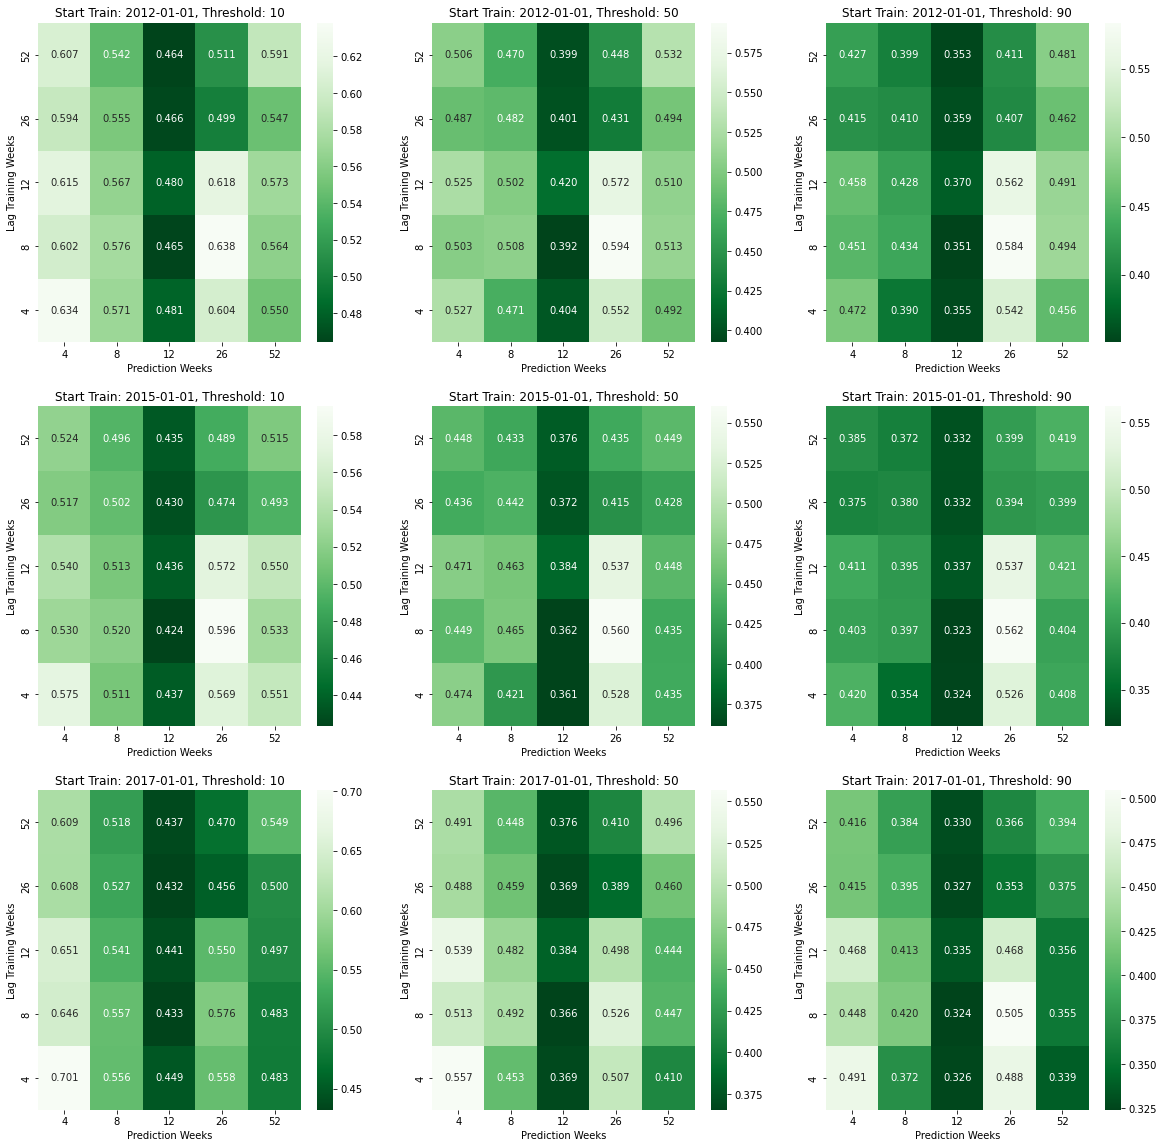

In [ ]:
fig, ax = plt.subplots(3,3, figsize = (20,20))

for i in range(3):
    sb.heatmap(prec_rec_aucs[i, :,:,0], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[0, i], xticklabels = weeks, yticklabels=lags)
    ax[0, i].set_title('Start Train: ' + start_train[0] + ', Threshold: ' + str(thresholds[i]))
    ax[0, i].set_xlabel('Prediction Weeks')
    ax[0, i].set_ylabel('Lag Training Weeks')
    ax[0, i].invert_yaxis()

    sb.heatmap(prec_rec_aucs[i, :,:,1], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[1, i], xticklabels = weeks, yticklabels=lags)
    ax[1, i].set_title('Start Train: ' + start_train[1] + ', Threshold: ' + str(thresholds[i]))
    ax[1, i].set_xlabel('Prediction Weeks')
    ax[1, i].set_ylabel('Lag Training Weeks')
    ax[1, i].invert_yaxis()

    sb.heatmap(prec_rec_aucs[i, :,:,2], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[2, i], xticklabels = weeks, yticklabels=lags)
    ax[2, i].set_title('Start Train: ' + start_train[2] + ', Threshold: ' + str(thresholds[i]))
    ax[2, i].set_xlabel('Prediction Weeks')
    ax[2, i].set_ylabel('Lag Training Weeks')
    ax[2, i].invert_yaxis()            

plt.show()

In [ ]:
start_pred = '2021-01-01'
start_train = ['2012-01-01', '2015-01-01', '2017-01-01']

X_list = ['MapDate', 'roff', 'evap', 'smap']
y_list = ['None']


# test run
weeks = [4, 8, 12, 26, 52]
lags = [4, 8, 12, 26, 52]
thresholds =  [10, 50, 90]

prec_rec_aucs = np.zeros((len(thresholds), len(lags), len(weeks), len(start_train)))


model = lm.LogisticRegression(max_iter = 1000, class_weight = 'balanced')


roc_aucs = []
results = []

for m, thresh in enumerate(thresholds):
    df_train_copy[y_list] = (df_train[y_list].values >= thresh).astype(int)
    df_test_copy[y_list] = (df_test[y_list].values >= thresh).astype(int)
    for i, week in tqdm(enumerate(weeks)):
        for j, lag in enumerate(lags):
            for k, start in enumerate(start_train):

                res = build_model(model, df_train_copy, df_test_copy, X_list, y_list, start_pred, week, lag = lag, start_train = start, loss = accuracy_score)
                
                lr_precision, lr_recall, _ = precision_recall_curve(res[5], res[0].predict_proba(res[4])[:,1])
                prec_rec_aucs[m, i, j, k] = auc(lr_recall, lr_precision)
                
                roc_aucs.append(roc_auc_score(res[5], res[0].predict_proba(res[4])[:,1]))
                results.append(res)
                
prec_rec_aucs = prec_rec_aucs.astype(float)


5it [00:47,  9.46s/it]
5it [00:47,  9.54s/it]
5it [00:48,  9.62s/it]


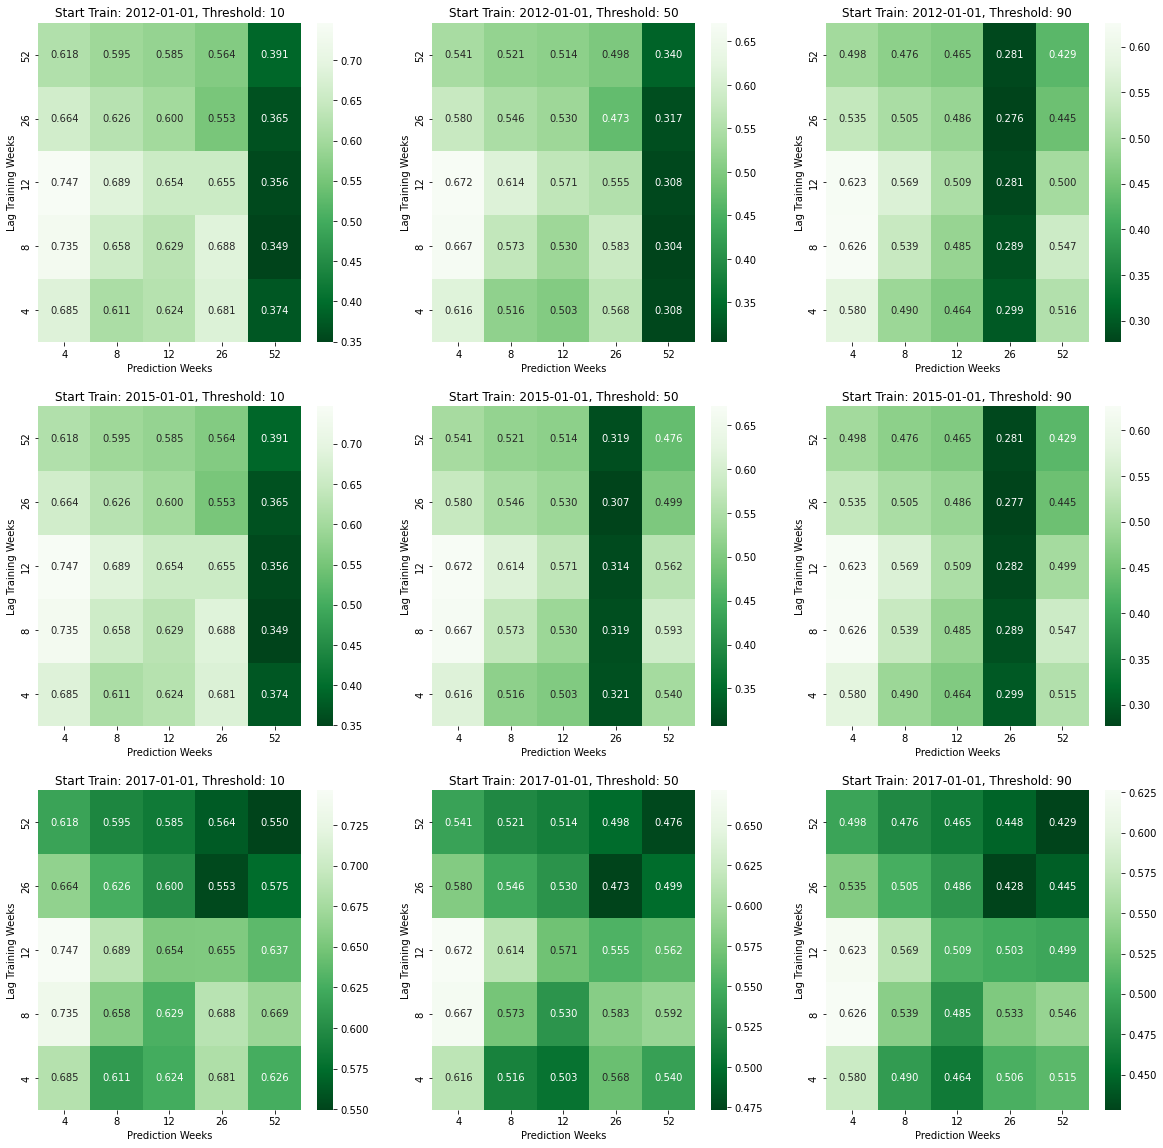

In [ ]:
fig, ax = plt.subplots(3,3, figsize = (20,20))

for i in range(3):
    sb.heatmap(prec_rec_aucs[i, :,:,0], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[0, i], xticklabels = weeks, yticklabels=lags)
    ax[0, i].set_title('Start Train: ' + start_train[0] + ', Threshold: ' + str(thresholds[i]))
    ax[0, i].set_xlabel('Prediction Weeks')
    ax[0, i].set_ylabel('Lag Training Weeks')
    ax[0, i].invert_yaxis()

    sb.heatmap(prec_rec_aucs[i, :,:,1], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[1, i], xticklabels = weeks, yticklabels=lags)
    ax[1, i].set_title('Start Train: ' + start_train[1] + ', Threshold: ' + str(thresholds[i]))
    ax[1, i].set_xlabel('Prediction Weeks')
    ax[1, i].set_ylabel('Lag Training Weeks')
    ax[1, i].invert_yaxis()

    sb.heatmap(prec_rec_aucs[i, :,:,2], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[2, i], xticklabels = weeks, yticklabels=lags)
    ax[2, i].set_title('Start Train: ' + start_train[2] + ', Threshold: ' + str(thresholds[i]))
    ax[2, i].set_xlabel('Prediction Weeks')
    ax[2, i].set_ylabel('Lag Training Weeks')
    ax[2, i].invert_yaxis()            

plt.show()

In [ ]:
start_pred = '2021-01-01'
start_train = ['2012-01-01', '2015-01-01', '2017-01-01']

X_list = ['MapDate', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN']
y_list = ['None']


# test run
weeks = [4, 8, 12, 26, 52]
lags = [4, 8, 12, 26, 52]
thresholds =  [10, 50, 90]

prec_rec_aucs = np.zeros((len(thresholds), len(lags), len(weeks), len(start_train)))


model = lm.LogisticRegression(max_iter = 1000, class_weight = 'balanced')


roc_aucs = []
results = []

for m, thresh in enumerate(thresholds):
    df_train_copy[y_list] = (df_train[y_list].values >= thresh).astype(int)
    df_test_copy[y_list] = (df_test[y_list].values >= thresh).astype(int)
    for i, week in tqdm(enumerate(weeks)):
        for j, lag in enumerate(lags):
            for k, start in enumerate(start_train):

                res = build_model(model, df_train_copy, df_test_copy, X_list, y_list, start_pred, week, lag = lag, start_train = start, loss = accuracy_score)
                
                lr_precision, lr_recall, _ = precision_recall_curve(res[5], res[0].predict_proba(res[4])[:,1])
                prec_rec_aucs[m, i, j, k] = auc(lr_recall, lr_precision)
                
                roc_aucs.append(roc_auc_score(res[5], res[0].predict_proba(res[4])[:,1]))
                results.append(res)
                
prec_rec_aucs = prec_rec_aucs.astype(float)


In [ ]:
fig, ax = plt.subplots(3,3, figsize = (20,20))

for i in range(3):
    sb.heatmap(prec_rec_aucs[i, :,:,0], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[0, i], xticklabels = weeks, yticklabels=lags)
    ax[0, i].set_title('Start Train: ' + start_train[0] + ', Threshold: ' + str(thresholds[i]))
    ax[0, i].set_xlabel('Prediction Weeks')
    ax[0, i].set_ylabel('Lag Training Weeks')
    ax[0, i].invert_yaxis()

    sb.heatmap(prec_rec_aucs[i, :,:,1], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[1, i], xticklabels = weeks, yticklabels=lags)
    ax[1, i].set_title('Start Train: ' + start_train[1] + ', Threshold: ' + str(thresholds[i]))
    ax[1, i].set_xlabel('Prediction Weeks')
    ax[1, i].set_ylabel('Lag Training Weeks')
    ax[1, i].invert_yaxis()

    sb.heatmap(prec_rec_aucs[i, :,:,2], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[2, i], xticklabels = weeks, yticklabels=lags)
    ax[2, i].set_title('Start Train: ' + start_train[2] + ', Threshold: ' + str(thresholds[i]))
    ax[2, i].set_xlabel('Prediction Weeks')
    ax[2, i].set_ylabel('Lag Training Weeks')
    ax[2, i].invert_yaxis()            

plt.show()

In [ ]:
start_pred = '2021-01-01'
start_train = ['2012-01-01', '2015-01-01', '2017-01-01']

X_list = ['MapDate', 'roff', 'evap', 'PRCP', 'SNWD', 'TMAX', 'TMIN']
y_list = ['None']


# test run
weeks = [4, 8, 12, 26, 52]
lags = [4, 8, 12, 26, 52]
thresholds =  [10, 50, 90]

prec_rec_aucs = np.zeros((len(thresholds), len(lags), len(weeks), len(start_train)))


model = lm.LogisticRegression(max_iter = 1000, class_weight = 'balanced')


roc_aucs = []
results = []

for m, thresh in enumerate(thresholds):
    df_train_copy[y_list] = (df_train[y_list].values >= thresh).astype(int)
    df_test_copy[y_list] = (df_test[y_list].values >= thresh).astype(int)
    for i, week in tqdm(enumerate(weeks)):
        for j, lag in enumerate(lags):
            for k, start in enumerate(start_train):

                res = build_model(model, df_train_copy, df_test_copy, X_list, y_list, start_pred, week, lag = lag, start_train = start, loss = accuracy_score)
                
                lr_precision, lr_recall, _ = precision_recall_curve(res[5], res[0].predict_proba(res[4])[:,1])
                prec_rec_aucs[m, i, j, k] = auc(lr_recall, lr_precision)
                
                roc_aucs.append(roc_auc_score(res[5], res[0].predict_proba(res[4])[:,1]))
                results.append(res)
                
prec_rec_aucs = prec_rec_aucs.astype(float)


In [ ]:
fig, ax = plt.subplots(3,3, figsize = (20,20))

for i in range(3):
    sb.heatmap(prec_rec_aucs[i, :,:,0], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[0, i], xticklabels = weeks, yticklabels=lags)
    ax[0, i].set_title('Start Train: ' + start_train[0] + ', Threshold: ' + str(thresholds[i]))
    ax[0, i].set_xlabel('Prediction Weeks')
    ax[0, i].set_ylabel('Lag Training Weeks')
    ax[0, i].invert_yaxis()

    sb.heatmap(prec_rec_aucs[i, :,:,1], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[1, i], xticklabels = weeks, yticklabels=lags)
    ax[1, i].set_title('Start Train: ' + start_train[1] + ', Threshold: ' + str(thresholds[i]))
    ax[1, i].set_xlabel('Prediction Weeks')
    ax[1, i].set_ylabel('Lag Training Weeks')
    ax[1, i].invert_yaxis()

    sb.heatmap(prec_rec_aucs[i, :,:,2], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[2, i], xticklabels = weeks, yticklabels=lags)
    ax[2, i].set_title('Start Train: ' + start_train[2] + ', Threshold: ' + str(thresholds[i]))
    ax[2, i].set_xlabel('Prediction Weeks')
    ax[2, i].set_ylabel('Lag Training Weeks')
    ax[2, i].invert_yaxis()            

plt.show()

In [ ]:
df_train_copy.columns

In [ ]:
start_pred = '2021-01-01'
start_train = ['2012-01-01', '2015-01-01', '2017-01-01']

X_list = ['MapDate', 'roff', 'evap', 'PRCP', 'TMAX', 'TMIN']
y_list = ['None']


# test run
weeks = [4, 8, 12, 26, 52]
lags = [4, 8, 12, 26, 52]
thresholds =  [10, 50, 90]

prec_rec_aucs = np.zeros((len(thresholds), len(lags), len(weeks), len(start_train)))


model = lm.LogisticRegression(max_iter = 1000, class_weight = 'balanced')


roc_aucs = []
results = []

for m, thresh in enumerate(thresholds):
    df_train_copy[y_list] = (df_train[y_list].values >= thresh).astype(int)
    df_test_copy[y_list] = (df_test[y_list].values >= thresh).astype(int)
    for i, week in tqdm(enumerate(weeks)):
        for j, lag in enumerate(lags):
            for k, start in enumerate(start_train):

                res = build_model(model, df_train_copy, df_test_copy, X_list, y_list, start_pred, week, lag = lag, start_train = start, loss = accuracy_score)
                
                lr_precision, lr_recall, _ = precision_recall_curve(res[5], res[0].predict_proba(res[4])[:,1])
                prec_rec_aucs[m, i, j, k] = auc(lr_recall, lr_precision)
                
                roc_aucs.append(roc_auc_score(res[5], res[0].predict_proba(res[4])[:,1]))
                results.append(res)
                
prec_rec_aucs = prec_rec_aucs.astype(float)

fig, ax = plt.subplots(3,3, figsize = (20,20))

for i in range(3):
    sb.heatmap(prec_rec_aucs[i, :,:,0], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[0, i], xticklabels = weeks, yticklabels=lags)
    ax[0, i].set_title('Start Train: ' + start_train[0] + ', Threshold: ' + str(thresholds[i]))
    ax[0, i].set_xlabel('Prediction Weeks')
    ax[0, i].set_ylabel('Lag Training Weeks')
    ax[0, i].invert_yaxis()

    sb.heatmap(prec_rec_aucs[i, :,:,1], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[1, i], xticklabels = weeks, yticklabels=lags)
    ax[1, i].set_title('Start Train: ' + start_train[1] + ', Threshold: ' + str(thresholds[i]))
    ax[1, i].set_xlabel('Prediction Weeks')
    ax[1, i].set_ylabel('Lag Training Weeks')
    ax[1, i].invert_yaxis()

    sb.heatmap(prec_rec_aucs[i, :,:,2], annot = True, cmap = 'Greens_r', fmt='.3f', ax = ax[2, i], xticklabels = weeks, yticklabels=lags)
    ax[2, i].set_title('Start Train: ' + start_train[2] + ', Threshold: ' + str(thresholds[i]))
    ax[2, i].set_xlabel('Prediction Weeks')
    ax[2, i].set_ylabel('Lag Training Weeks')
    ax[2, i].invert_yaxis()            

plt.show()


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.573


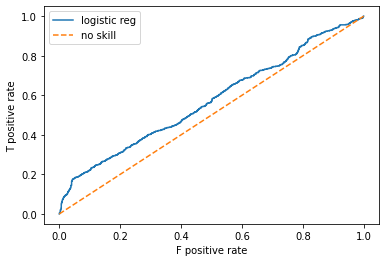

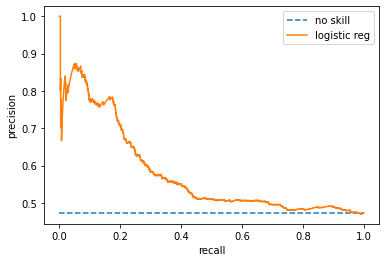

In [ ]:
# Best model seems to include lag of 12 predicing 26 weeks


thresh = 0.9
week = 26
lag = 8
start = '2012-01-01'

X_list = ['MapDate', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN']
y_list = ['None']

model = lm.LogisticRegression(max_iter = 1000)
start_pred = '2021-01-01'

df_train_copy[y_list] = (df_train[y_list].values >= thresh).astype(int)
df_test_copy[y_list] = (df_test[y_list].values >= thresh).astype(int)

res = build_model(model, df_train_copy, df_test_copy, X_list, y_list, start_pred, pred_time = week, lag = lag, start_train = start, loss = accuracy_score)

lr_fpr, lr_tpr, _ = roc_curve(res[5], res[0].predict_proba(res[4])[:,1])
ns_fpr, ns_tpr, _ = roc_curve(res[5], np.ones(len(res[5])))

# calculate scores
ns_auc = roc_auc_score(res[5], np.ones(len(res[5])))
lr_auc = roc_auc_score(res[5], res[0].predict_proba(res[4])[:,1])
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
plt.plot(lr_fpr, lr_tpr, label = 'logistic reg')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label = 'no skill')
plt.legend()
plt.xlabel('F positive rate')
plt.ylabel('T positive rate')
plt.show()

# Precision-Recall curve
lr_precision, lr_recall, _ = precision_recall_curve(res[5], res[0].predict_proba(res[4])[:,1])
ns = res[5][res[5]==1].sum() / len(res[5])
plt.plot([0, 1], [ns, ns], linestyle='--', label='no skill')
plt.plot(lr_recall, lr_precision, label='logistic reg')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.show()


None    1104.0
dtype: float64

In [ ]:
print(classification_report(res[5], res[1], zero_division = 0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1236
           1       0.47      1.00      0.64      1104

    accuracy                           0.47      2340
   macro avg       0.24      0.50      0.32      2340
weighted avg       0.22      0.47      0.30      2340



### Multinomial Regression based on drought type

In [1]:
start_pred = '2021-01-01'
start_train = ['2012-01-01', '2015-01-01', '2017-01-01']

X_list = ['MapDate', 'roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']
y_list = ['d_type']



# test run
weeks = [4, 8, 12, 26, 52]
lags = [4, 8, 12, 26, 52]


results = np.zeros((len(lags), len(weeks), len(start_train)))

scaler = StandardScaler()



model = lm.LogisticRegression(multi_class='multinomial', solver='saga', max_iter = 200)

df_train_copy = df_train.copy()
df_test_copy = df_test.copy()


df_train_copy[X_list[1:]] = scaler.fit_transform(df_train_copy[X_list[1:]].values)
df_test_copy[X_list[1:]] = scaler.fit_transform(df_test_copy[X_list[1:]].values)



for i, week in tqdm(enumerate(weeks)):
    for j, lag in enumerate(lags):
        for k, start in enumerate(start_train):
            res = build_model(model, df_train_copy, df_test_copy, X_list, y_list, start_pred, week, lag = lag, start_train = start, loss = accuracy_score)
            results[i, j, k] = res[2]

results = results.astype(float)


In [ ]:
fig, ax = plt.subplots(1,3, figsize = (20,5))

sb.heatmap(results[:,:,0], annot = True, cmap = 'Greens_r', fmt='.4f', ax = ax[0], xticklabels = weeks, yticklabels=lags)
ax[0].set_title('Start Train: ' + start_train[0])
ax[0].set_xlabel('Prediction Weeks')
ax[0].set_ylabel('Lag Training Weeks')
ax[0].invert_yaxis()

sb.heatmap(results[:,:,1], annot = True, cmap = 'Greens_r', fmt='.4f', ax = ax[1], xticklabels = weeks, yticklabels=lags)
ax[1].set_title('Start Train: ' + start_train[1])
ax[1].set_xlabel('Prediction Weeks')
ax[1].set_ylabel('Lag Training Weeks')
ax[1].invert_yaxis()

sb.heatmap(results[:,:,2], annot = True, cmap = 'Greens_r', fmt='.4f', ax = ax[2], xticklabels = weeks, yticklabels=lags)
ax[2].set_title('Start Train: ' + start_train[2])
ax[2].set_xlabel('Prediction Weeks')
ax[2].set_ylabel('Lag Training Weeks')
ax[2].invert_yaxis()

plt.show()

#### Old EDA of a single county or group of counties

In [ ]:
# OLD EDA JUST FOR FUN

dates = pd.to_datetime(df_full[df_full['FIPS'] == FIPS[0]]['MapDate'])

fig,ax = plt.subplots(figsize=(10,10))

ln1 = ax.plot(dates, df_full[df_full['FIPS'] == FIPS[0]]['smap'], color = 'b', alpha = 0.5, label = 'SMAP')
ax.set_xlabel("measurement week")
ax.set_ylabel("smap")
ax.xaxis_date()

date_form = DateFormatter('%d-%m-%y')
ax.xaxis.set_major_formatter(date_form)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=30))

ax2=ax.twinx()
ln2 = ax2.plot(dates, df_full[df_full['FIPS'] == FIPS[0]]['roff'], color = 'r', alpha = 0.5, label = 'RunOff')
ln3 = ax2.plot(dates, df_full[df_full['FIPS'] == FIPS[0]]['evap'], color = 'g', alpha = 0.5, label = 'Evap')
ax2.set_ylabel("inches of roff or evap")

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


fig.autofmt_xdate()

plt.show()

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.134
Model:                            OLS   Adj. R-squared (uncentered):              0.126
Method:                 Least Squares   F-statistic:                              17.98
Date:                Tue, 29 Mar 2022   Prob (F-statistic):                    7.09e-11
Time:                        14:18:37   Log-Likelihood:                         -2400.4
No. Observations:                 353   AIC:                                      4807.
Df Residuals:                     350   BIC:                                      4818.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

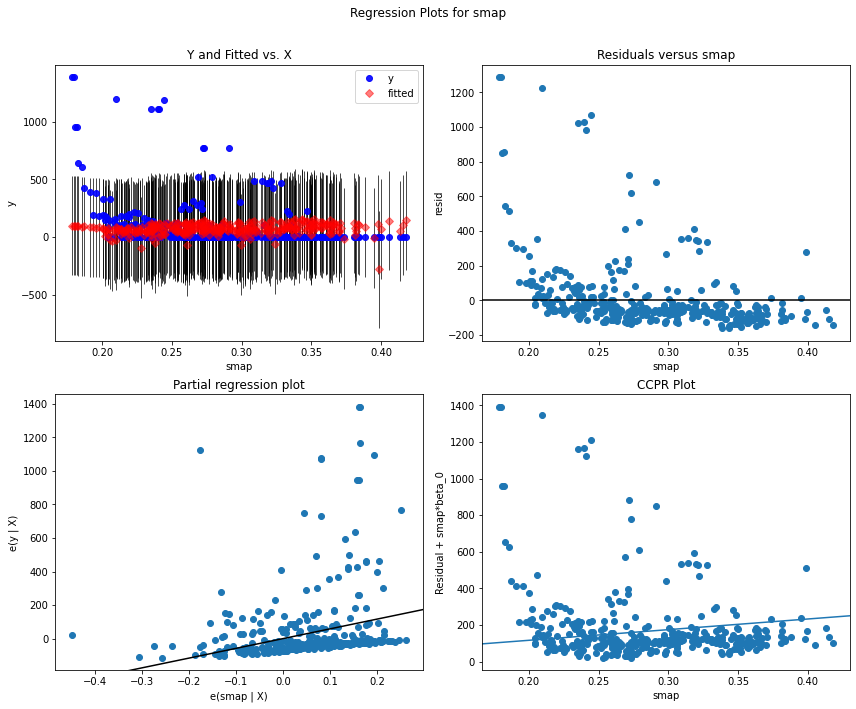

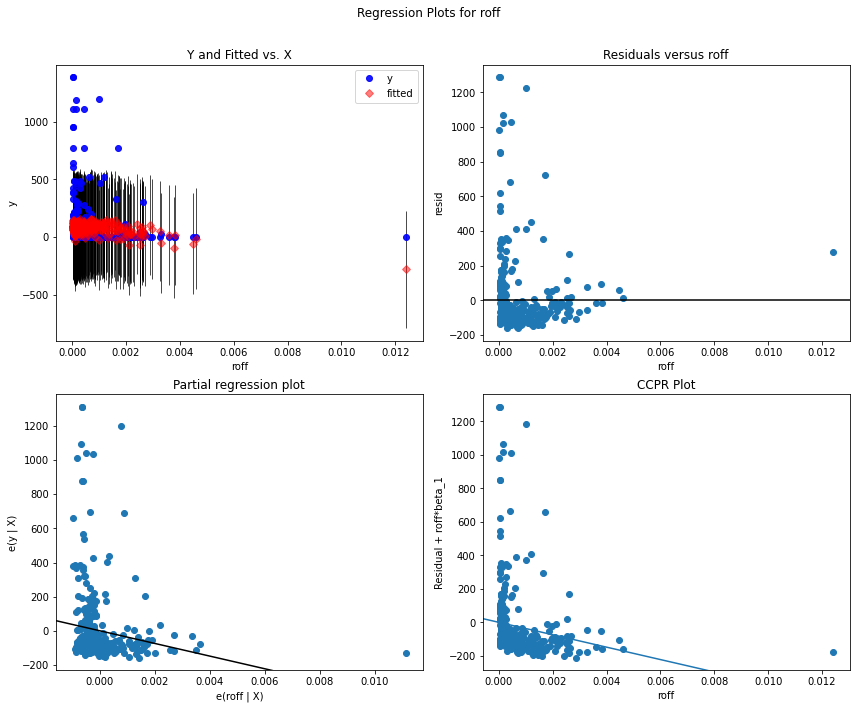

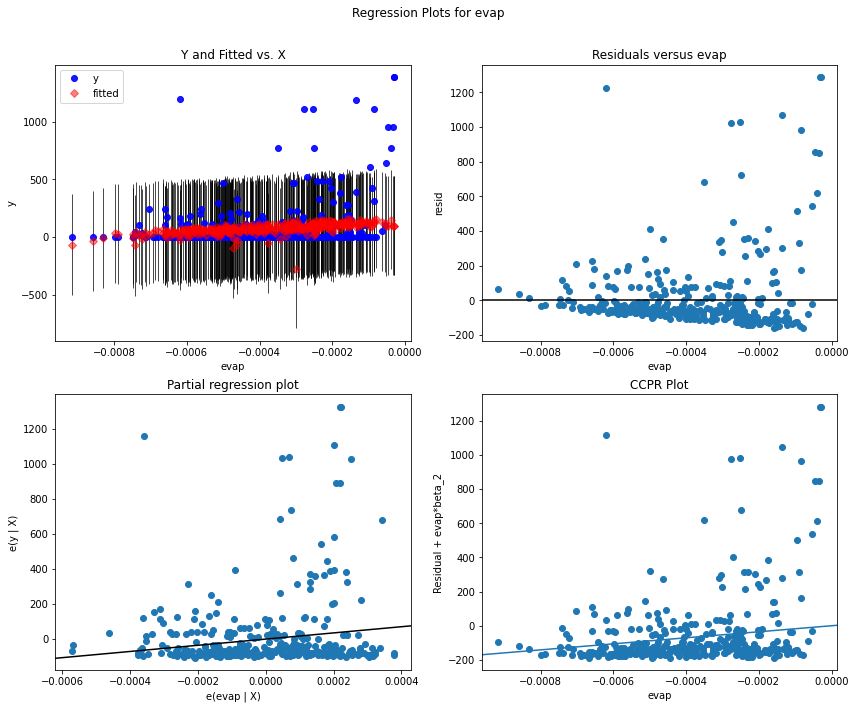

<Figure size 864x720 with 0 Axes>

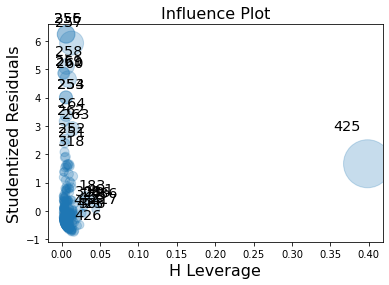

In [ ]:
#sample FIPS[0]

df_fips_0 = df_full[df_full['FIPS'] == FIPS[0]]
       
X_col = ['smap', 'roff', 'evap']
y_col = 'wsum'

X = df_fips_0[X_col]
y = np.array(df_fips_0[y_col]).reshape(-1,1)


lm = sm.OLS(y, X, missing = 'drop')
results = lm.fit()
print(results.summary())

fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 0, fig = fig)
plt.show()
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 1, fig = fig)
plt.show()
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 2, fig = fig)
plt.show()

fig = plt.figure(figsize=(12,10))
sm.graphics.influence_plot(results, fig = fig, plot_alpha=.25)
plt.show()





                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.173
Model:                            OLS   Adj. R-squared (uncentered):              0.166
Method:                 Least Squares   F-statistic:                              24.49
Date:                Tue, 29 Mar 2022   Prob (F-statistic):                    2.09e-14
Time:                        14:18:46   Log-Likelihood:                         -521.39
No. Observations:                 353   AIC:                                      1049.
Df Residuals:                     350   BIC:                                      1060.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

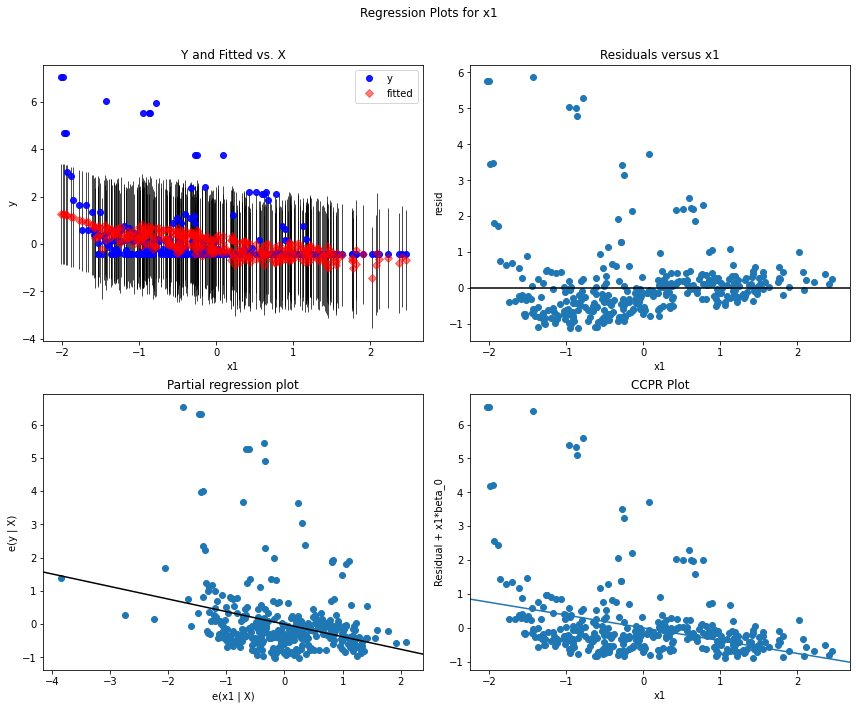

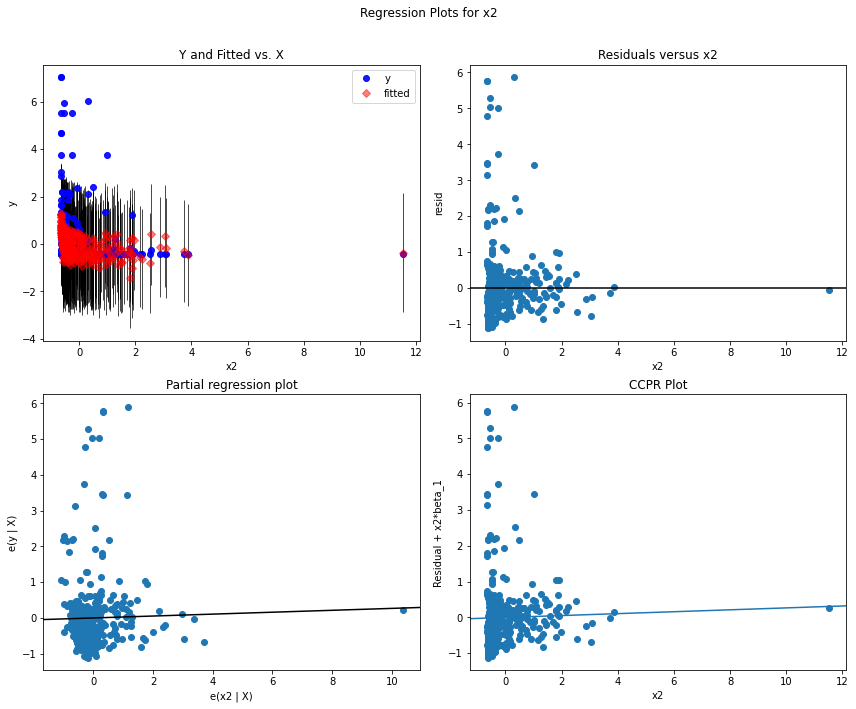

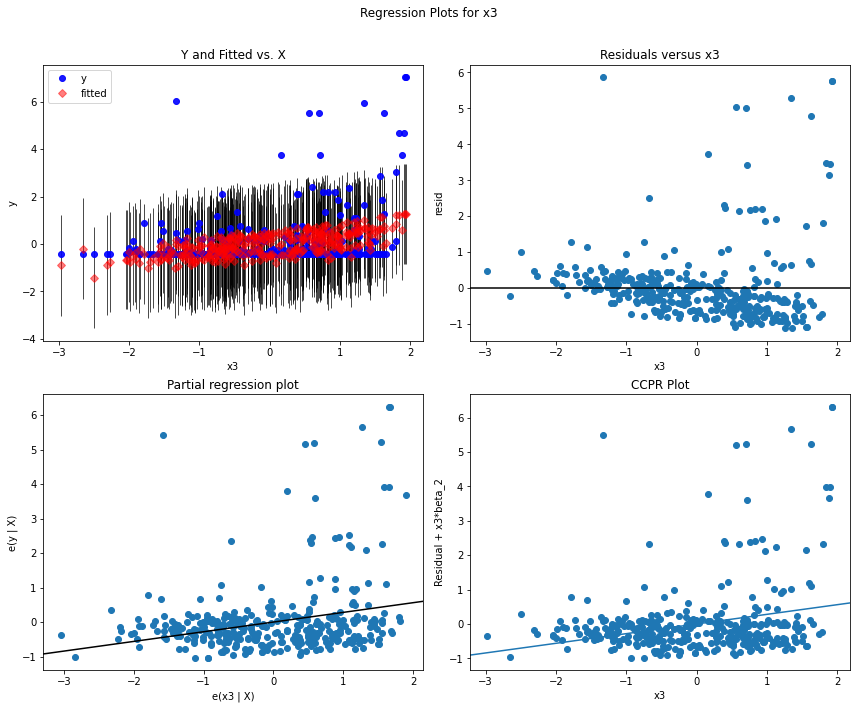

In [ ]:
#sample FIPS[0]

df_fips_0 = df_full[df_full['FIPS'] == FIPS[0]]
       
X_col = ['smap', 'roff', 'evap']
y_col = 'wsum'

X = df_fips_0[X_col]
y = np.array(df_fips_0[y_col]).reshape(-1,1)

scaler = StandardScaler()

X = scaler.fit_transform(X)

y = scaler.fit_transform(y)

lm = sm.OLS(y, X, missing = 'drop')
results = lm.fit()
print(results.summary())

fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 0, fig = fig)
plt.show()
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 1, fig = fig)
plt.show()
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 2, fig = fig)
plt.show()



<Figure size 864x720 with 0 Axes>

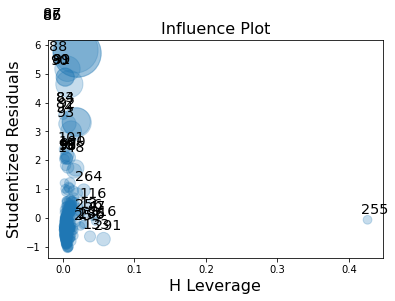

In [ ]:
# fig = plt.figure(figsize=(12,10))
# sm.graphics.plot_partregress_grid(results, fig = fig)
# plt.show()

fig = plt.figure(figsize=(12,10))
sm.graphics.influence_plot(results, fig = fig, plot_alpha=.25)
plt.show()
